In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyfuncs.utils import load_nodes_map, load_genes_map, map_node_name

In [2]:
# Load data
sample = np.abs(np.loadtxt("Data/sample.txt")).T
# Frequencies
frequencies = sample.mean(axis=0)
# Cancer sample idx
cancer_idx = np.loadtxt('Data/cancer_sample.txt', dtype=int) - 1
cancer_sample = sample[cancer_idx, :]
# Normal sample idx
normal_idx = np.ones(sample.shape[0], dtype=bool)
normal_idx[cancer_idx] = 0
normal_sample = sample[normal_idx, :]
# Compressed nodes dict
compressed_nodes_map = load_nodes_map("Data/nodes.txt")
# Genes names maps
genes_map = load_genes_map("Data/names.txt")
# Brownian sample
brownian_sample = np.loadtxt('result_files/brownian_sample.txt').astype(int)
brownian_cancer_sample = brownian_sample[cancer_idx, :]
# Load graph
Graph = nx.read_adjlist('Data/gene_network.adjlist', create_using=nx.DiGraph, nodetype=int)
# Import genecards PRAD genes
prad_genecards = pd.read_csv('Data/GeneCards-PRAD.csv').iloc[:, [0, 5]]


# Build Supplementary Table I

In [29]:
nodes_idx = np.arange(Graph.number_of_nodes())
freqs = sample.mean(axis=0)
freqs_c = cancer_sample.mean(axis=0)
freqs_n = normal_sample.mean(axis=0)
in_degree = np.array([Graph.in_degree[k] for k in nodes_idx], dtype=int)
out_degree = np.array([Graph.out_degree[k] for k in nodes_idx], dtype=int)

# Build childs array
associated = [compressed_nodes_map[i] for i in nodes_idx]
associated_genes = []
for elems in associated:
    temp = []
    for elem in elems:
        temp.append(genes_map[elem])
    associated_genes.append(temp)

associated_genes = [str(elem)[1:-1].replace("'", "") for elem in associated_genes]


# Multiplicity
multiplicity = [len(compressed_nodes_map[i]) for i in nodes_idx]

df = pd.DataFrame({'Node': nodes_idx, 'Frequency': freqs.round(4),
                  'Frequency_in_cancer': freqs_c.round(4), 'Frequency_in_Normal': freqs_n.round(4),'In_Degree': in_degree, 
                  'Out_Degree': out_degree, 'Multiplicity': multiplicity,
                  'Associated_genes': associated_genes})
#df.to_csv('Supplementary Materials/Table I.csv', index=False) 

# Establish gene concepts

In [4]:
concepts = ['None'] * sample.shape[1]

normal_concept = np.where(normal_sample.mean(axis=0) == 0)[0]
#cancer_concept = np.where(cancer_sample.mean(axis=0) > .9)[0]

for i in normal_concept:
    concepts[i] = 'Normal'

# for i in cancer_concept:
#     concepts[i] = 'Cancer'

concepts = np.array(concepts)

# Identify chain starts

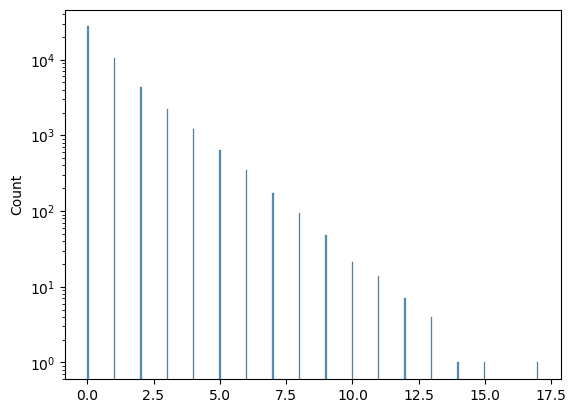

In [5]:
sns.histplot(brownian_cancer_sample.sum(axis=0))
plt.yscale('log')

In [6]:
chain_starts = np.where(brownian_cancer_sample.sum(axis=0) > 0)[0]
starts_freqs = brownian_cancer_sample.sum(axis=0)[chain_starts] / brownian_cancer_sample.shape[0]
ordered_idx = np.argsort(starts_freqs)[::-1]
chain_starts, starts_freqs = chain_starts[ordered_idx], starts_freqs[ordered_idx]

In [7]:
# Save chain starts 
chain_heads = []
max_compressed_frequency = True

# with open('result_files/brownian_cancer_starts', 'w') as file:
#     for node, freq in zip(chain_starts, starts_freqs):
#         nodes = compressed_nodes_map[node]
#         chain_heads.append(nodes)
#         if len(nodes) > 1 and max_compressed_frequency:
#             print('Ngenes: ', len(nodes), '\tNsamples: ', round(freq * brownian_cancer_sample.shape[0]))
#             max_compressed_frequency = False
#         line = f'{freq:.3}\t'
#         for gene in nodes:
#             line = line + genes_map[gene] + '\t'
#         line = line + '\n'
#         file.write(line)

Ngenes:  2 	Nsamples:  1


# Number of dysregulated genes

In [8]:
# Cancer dysregulated sample
dysregulated_cancer = np.zeros_like(cancer_sample)
for i in range(dysregulated_cancer.shape[0]):
    for j in range(dysregulated_cancer.shape[1]):
        if cancer_sample[i, j] == 1:
            dysregulated_cancer[i, j] = len(compressed_nodes_map[j])

# Normal dysregulated sample
dysregulated_normal = np.zeros_like(normal_sample)
for i in range(dysregulated_normal.shape[0]):
    for j in range(dysregulated_normal.shape[1]):
        if normal_sample[i, j] == 1:
            dysregulated_normal[i, j] = len(compressed_nodes_map[j])

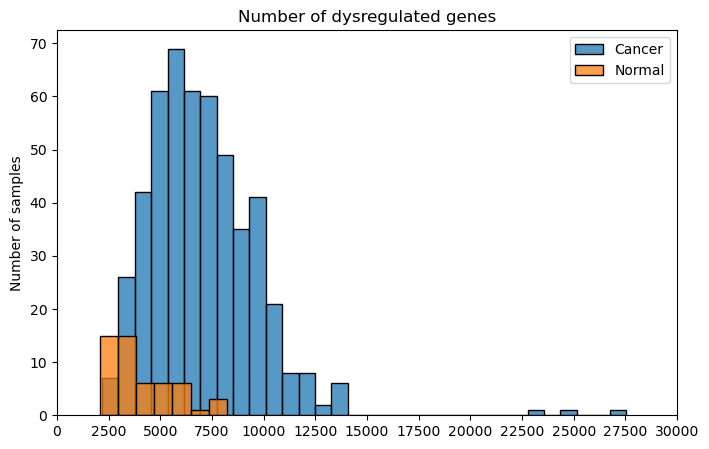

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(dysregulated_cancer.sum(axis=1), label='Cancer')
sns.histplot(dysregulated_normal.sum(axis=1), label='Normal')
plt.title('Number of dysregulated genes')
plt.legend()
plt.xticks(np.arange(0, 30001, 2500))
plt.ylabel('Number of samples')
#plt.savefig('Charts/Dysregulated_genes.pdf')
#plt.yscale('log')
plt.show()

# Minimum graph

In [10]:
min_dysreg_sample_idx = np.argmin(dysregulated_cancer.sum(axis=1))
min_dysreg_nodes = np.where(cancer_sample[min_dysreg_sample_idx, :] > 0)[0]
min_dysreg_nodes

array([   49,    60,    74, ..., 46904, 46915, 46922])

In [11]:
min_Graph = Graph.subgraph(min_dysreg_nodes)
# pos = nx.spring_layout(min_Graph)
#nx.write_gexf(Graph, 'result_files/graph.gexf')
#nx.draw(min_Graph, pos=pos)

# Minimum samples

In [12]:
brownian_normal_sample = brownian_sample[normal_idx, :]
# brownian_normal_sample.sum(axis=1)
br_cl2 = np.where(brownian_normal_sample.sum(axis=1) < 50)[0]
min_normal_arg = np.argmin(normal_sample[br_cl2].sum(axis=1)), 
min_normal = normal_sample[br_cl2][min_normal_arg]

In [13]:
'Total dysregulations in minimal cancer sample ' + str(dysregulated_cancer.sum(axis=1)[np.argmin(cancer_sample.sum(axis=1))])

'Total dysregulations in minimal cancer sample 2182.0'

In [14]:
# Identify cancer sample with least amount of deregulations
min_cancer_sample = np.argmin(cancer_sample.sum(axis=1))
min_cancer = cancer_sample[min_cancer_sample, :]
#min_normal_sample = np.argmin(normal_sample.sum(axis=1))

# Indexes of altered nodes in minimal samples
min_cancer_idx = np.where(cancer_sample[min_cancer_sample, :] == 1)[0]
min_normal_idx = np.where(normal_sample[br_cl2][min_normal_arg] == 1)[0]

# Frequencies of nodes in minimal samples
min_freq_cancer = [freqs_c[i] for i in min_cancer_idx]
min_freq_normal = [freqs_c[i] for i in min_normal_idx]

# Outdegree of nodes in minimal samples
min_dgr_cancer = [Graph.degree[i] for i in min_cancer_idx]
min_dgr_normal = [Graph.degree[i] for i in min_normal_idx]      

# Min frequeccy genes
min_freq_cancer_idx = np.argmin(freqs_c[min_cancer_idx])
min_freq_cancer_idx = min_cancer_idx[min_freq_cancer_idx]
print(map_node_name(min_freq_cancer_idx, compressed_nodes_map, genes_map))

min_freq_normal_idx = np.argmin(freqs_c[min_normal_idx])
min_freq_normal_idx = min_normal_idx[min_freq_normal_idx]
print(map_node_name(min_freq_normal_idx, compressed_nodes_map, genes_map))

['FAM215A']
['BPIFB6']


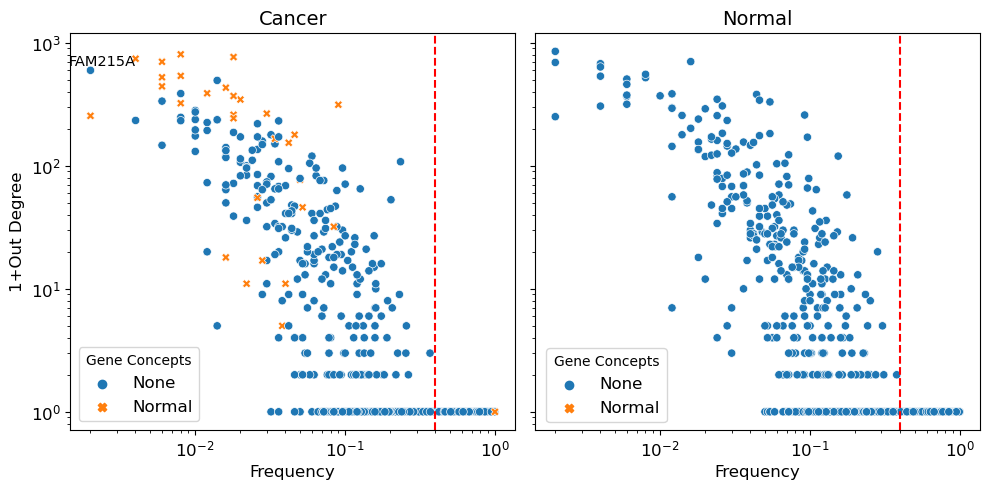

In [17]:
min_odgr_cancer = [Graph.out_degree[i] for i in min_cancer_idx]
min_odgr_normal = [Graph.out_degree[i] for i in min_normal_idx]

hue_normal = concepts[min_normal_idx]
hue_cancer = concepts[min_cancer_idx]

fs = 12

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey="row")
sns.scatterplot(
    x=min_freq_cancer,
    y=1 + np.asarray(min_odgr_cancer),
    ax=ax[0],
    hue=hue_cancer,
    style=hue_cancer,
)
sns.scatterplot(
    x=min_freq_normal,
    y=1 + np.asarray(min_odgr_normal),
    ax=ax[1],
    hue=hue_normal,
    legend=False,
)

ax[0].set_ylabel("1+Out Degree", fontsize=fs)
ax[0].set_xlabel("Frequency", fontsize=fs)
ax[0].set_title("Cancer", fontsize=fs + 2)
ax[0].tick_params(labelsize=12)
ax[0].axvline(0.4, ls="--", c="r")

ax[1].set_title("Normal", fontsize=fs + 2)
ax[1].set_xlabel("Frequency", fontsize=fs)
ax[1].tick_params(labelsize=12)
ax[1].axvline(0.4, ls="--", c="r")

ax[0].annotate(
    map_node_name(min_freq_cancer_idx, compressed_nodes_map, genes_map)[0],
    (freqs_c[min_freq_cancer_idx], 1 + Graph.out_degree[min_freq_cancer_idx]),
    (freqs_c[min_freq_cancer_idx] * 1.2, 50 + Graph.out_degree[min_freq_cancer_idx]),
    ha='center',
    fontsize=10.5
)

ax[1].annotate(
    map_node_name(min_freq_normal_idx, compressed_nodes_map, genes_map)[0],
    (freqs_c[min_freq_normal_idx], 1 + Graph.out_degree[min_freq_normal_idx]),
    (freqs_c[min_freq_normal_idx] * 1.2, 50 + Graph.out_degree[min_freq_normal_idx]),
    ha='center',
    fontsize=10.5
)

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")

ax[0].legend(title="Gene Concepts", fontsize=12)
# ax[1].legend(False)
fig.legend(loc="upper right", bbox_to_anchor=(0.68, 0.31), title="Gene Concepts", fontsize=12)
fig.tight_layout()
#plt.savefig('Charts/Fig3 (Frequency in cancer).pdf')

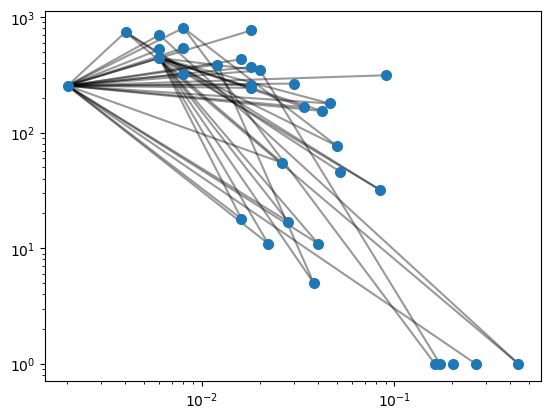

In [58]:
# Draw minimun graph
idx = np.intersect1d(normal_concept, min_cancer_idx)
idx = np.delete(idx, -1)
for i in idx:
    childs = list(nx.descendants_at_distance(Graph, i, 1))
    inter = np.intersect1d(childs, idx)
    if inter.size > 0:
        for j in inter:
            plt.plot([freqs_c[i], freqs_c[j]], [1+out_degree[i], 1+out_degree[j]], 'k', alpha=0.4)

plt.plot(freqs_c[idx], 1+out_degree[idx], 'o',markersize=7)
plt.yscale("log")
plt.xscale("log")

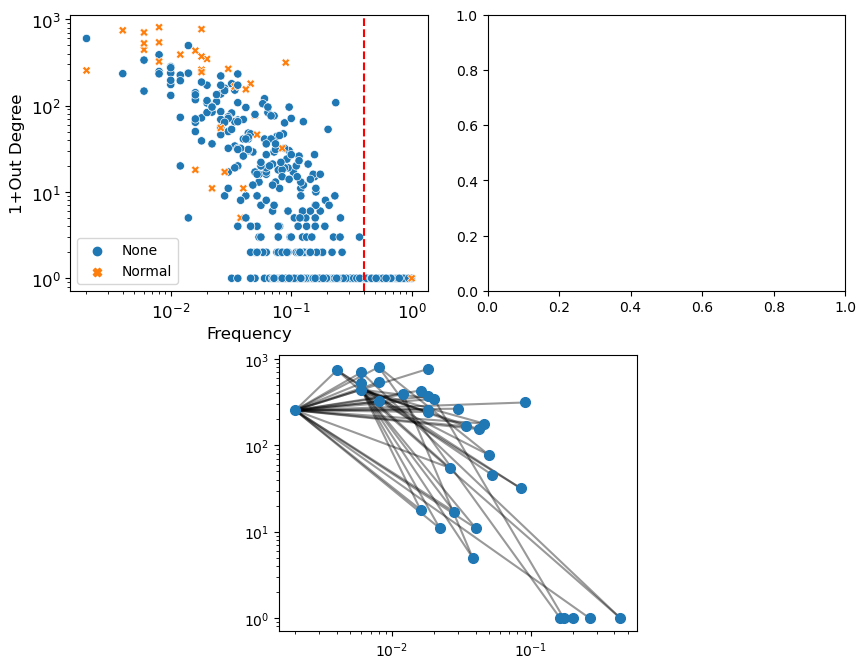

In [74]:
fig = plt.figure(figsize=(10, 8))
grid = plt.GridSpec(4, 4, hspace=0.6, wspace=0.4)
cancer_ax = fig.add_subplot(grid[:2, :2])
normal_ax = fig.add_subplot(grid[:2, 2:])
graph_ax = fig.add_subplot(grid[2:, 1:3])

# Cancer box
sns.scatterplot(
    x=min_freq_cancer,
    y=1 + np.asarray(min_odgr_cancer),
    ax=cancer_ax,
    hue=hue_cancer,
    style=hue_cancer,
)

cancer_ax.set_ylabel("1+Out Degree", fontsize=fs)
cancer_ax.set_xlabel("Frequency", fontsize=fs)
#cancer_ax.set_title("Cancer", fontsize=fs + 2)
cancer_ax.tick_params(labelsize=12)
cancer_ax.axvline(0.4, ls="--", c="r")
cancer_ax.set_yscale("log")
cancer_ax.set_xscale("log")


# grpah box
for i in idx:
    childs = list(nx.descendants_at_distance(Graph, i, 1))
    inter = np.intersect1d(childs, idx)
    if inter.size > 0:
        for j in inter:
            graph_ax.plot([freqs_c[i], freqs_c[j]], [1+out_degree[i], 1+out_degree[j]], 'k', alpha=0.4)

graph_ax.plot(freqs_c[idx], 1+out_degree[idx], 'o',markersize=7)
graph_ax.set_yscale("log")
graph_ax.set_xscale("log")

### Number of outdegree genes

In [51]:
min_odgr_cancer = np.array(min_odgr_cancer)
min_odgr_normal = np.array(min_odgr_normal)

print(f'Number of out_degree genes in min_cancer: {(min_odgr_cancer > 0).sum()}')
print(f'Number of out_degree genes in min_normal: {(min_odgr_normal > 0).sum()}')

Number of out_degree genes in min_cancer: 256
Number of out_degree genes in min_normal: 278


### Common outdegree genes

In [52]:
outdgr_canc = min_cancer_idx[np.where(min_odgr_cancer > 0)[0]]
outdgr_norm = min_normal_idx[np.where(min_odgr_normal > 0)[0]]
np.savetxt('result_files/outdegree_commons.txt', np.intersect1d(outdgr_canc, outdgr_norm), fmt='%i')

### Indegree and frequency

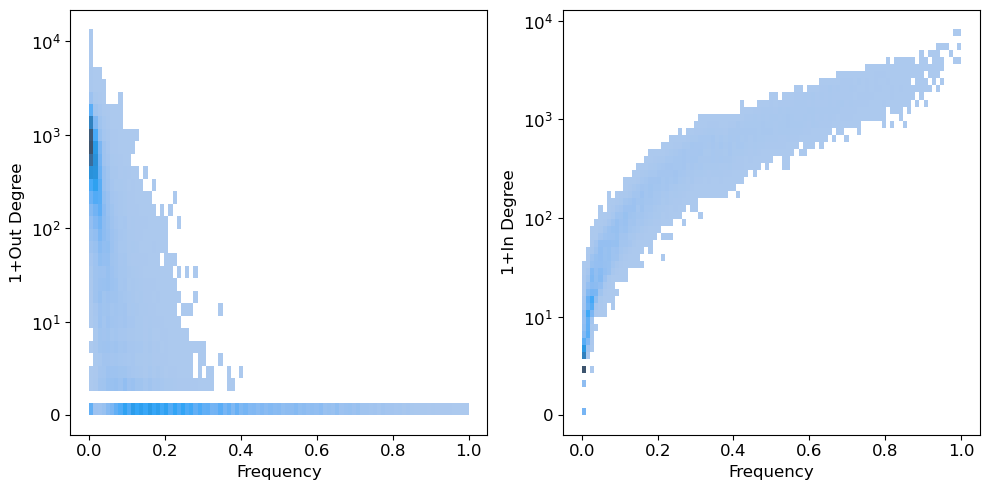

In [65]:
min_idgr_cancer = np.array([Graph.in_degree[i] for i in min_cancer_idx])
min_idgr_normal = np.array([Graph.in_degree[i] for i in min_normal_idx])

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
sns.histplot(y=np.log10(1+np.array(in_degree)), x=freqs_c, cbar=False, ax=ax[1])
sns.histplot(y=np.log10(1+np.array(out_degree)), x=freqs_c, cbar=False, ax=ax[0])

ax[1].set_ylabel('1+In Degree', fontsize=12)
ax[0].set_ylabel('1+Out Degree', fontsize=12)
#ax[0].set_title('Cancer')
ax[1].set_xlabel('Frequency', fontsize=12)
#ax[0].set_yscale('log')
#ax[1].set_title('Normal')
ax[0].set_xlabel('Frequency', fontsize=12)
ax[1].set_yticks([0, 1, 2, 3, 4], ['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax[0].set_yticks([0, 1, 2, 3, 4], ['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax[1].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

fig.tight_layout()
#plt.savefig('Charts/Fig1 (no Cbar).pdf')

# Childelss frequencies

In [54]:
childless = [k for k in range(Graph.number_of_nodes()) if Graph.out_degree()[k] == 0]
len(childless)

19460

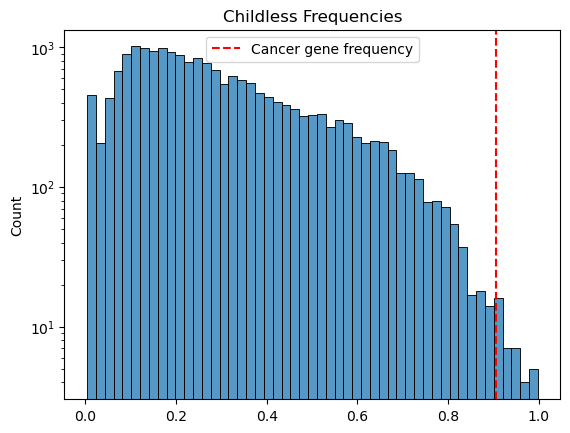

In [55]:
sns.histplot(sample[:, childless].mean(axis=0))
plt.axvline(sample[:, -1].mean(), ls='--', c='r', label='Cancer gene frequency')
plt.yscale('log')
plt.title('Childless Frequencies')
plt.legend()
#plt.savefig('Charts/Childless_frequencies.pdf')

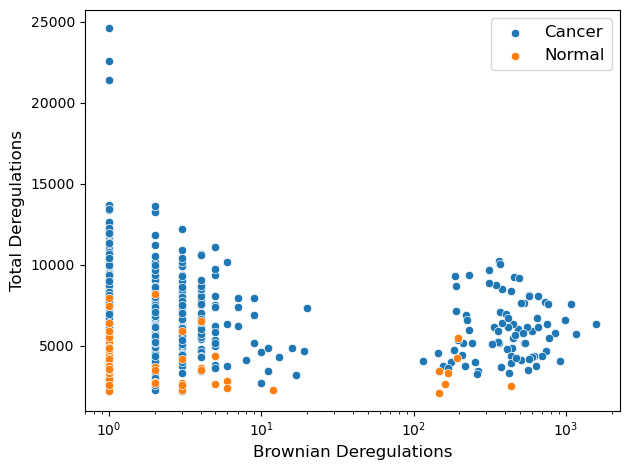

In [26]:
# Plot total dusregulations vs brownian dysregulations
x_c = brownian_cancer_sample.sum(axis=1)
x_n = brownian_sample[normal_idx, :].sum(axis=1)
y_c = cancer_sample.sum(axis=1)
y_n = normal_sample.sum(axis=1)
sns.scatterplot(x=x_c, y=y_c, label='Cancer')
sns.scatterplot(x=x_n, y=y_n, label='Normal')
plt.xlabel('Brownian Deregulations', fontsize=12)
plt.ylabel('Total Deregulations', fontsize=12)
plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
#plt.savefig('Charts/Fig2.pdf')

In [57]:
(x_c < 50).sum(), (x_n < 50).sum(), (x_c < 50).sum() + (x_n < 50).sum()

(418, 45, 463)

# Group 2 Intersections

Text(0.5, 1.0, 'Gene coincidences in cluster 2 (88 samples)')

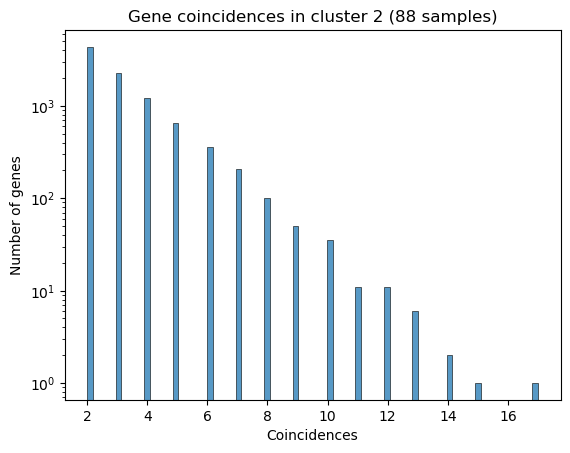

In [58]:
brown_2 = brownian_sample[(brownian_sample.sum(axis=1) > 50), :]
sns.histplot(brown_2.sum(axis=0)[(brown_2.sum(axis=0) > 1)])
plt.yscale('log')
plt.xlabel('Coincidences')
plt.ylabel('Number of genes')
plt.title('Gene coincidences in cluster 2 (88 samples)')
#plt.savefig('Charts/CL2_coincidences.pdf')

# Group 1 degree and dysregulations

In [59]:
# with open('result_files/Cluster1.txt', mode='w') as f:
#     for i in range(brownian_normal_sample.shape[0]):
#         nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) < 50:
#             write = True
#             line = f'{dysregulated_normal[i, :].sum().astype(int)}\tNormal\t'
#             for node in nodes:
#                 line = line + str(Graph.out_degree[node]) + '{'
#                 genes = compressed_nodes_map[node]
#                 for n, gene in enumerate(genes):
#                     if n > 0:
#                         line = line + ', '
#                     line = line + genes_map[gene]
#                 line = line + '}\t'
#         if write:
#             line = line + '\n'
#             f.write(line)

#     for i in range(brownian_cancer_sample.shape[0]):
#         nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) < 50:
#             write = True
#             line = f'{dysregulated_cancer[i, :].sum().astype(int)}\tCancer\t'
#             for node in nodes:
#                 line = line + str(Graph.out_degree[node]) + '{'
#                 genes = compressed_nodes_map[node]
#                 for n, gene in enumerate(genes):
#                     if n > 0:
#                         line = line + ', '
#                     #print(gene, genes_map[gene])
#                     line = line + genes_map[gene]
#                 line = line + '}\t'
#         if write:
#             line = line + '\n'
#             f.write(line)

### Alternative table

In [60]:
# with open('result_files/Cluster1_supplement.csv', mode='w') as f:
#     f.write('Total Dysregulations,Sample Type,Altered Brownian Nodes\n')
#     for i in range(brownian_normal_sample.shape[0]):
#         nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) < 50:
#             write = True
#             line = f'{dysregulated_normal[i, :].sum().astype(int)},Normal,'
#             for node in nodes:
#                 line = line + str(node) + ','
#         if write:
#             line = line + '\n'
#             f.write(line)

#     for i in range(brownian_cancer_sample.shape[0]):
#         nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) < 50:
#             write = True
#             line = f'{dysregulated_cancer[i, :].sum().astype(int)},Tumor,'
#             for node in nodes:
#                 line = line + str(node) + ','
#         if write:
#             line = line + '\n'
#             f.write(line)

# Group 2 degree and dysregulations

In [61]:
# with open('result_files/Cluster2.txt', mode='w') as f:
#     for i in range(brownian_normal_sample.shape[0]):
#         nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) > 50:
#             write = True
#             line = f'{dysregulated_normal[i, :].sum().astype(int)}\tNormal\t'
#             for node in nodes:
#                 line = line + str(Graph.out_degree[node]) + '{'
#                 genes = compressed_nodes_map[node]
#                 for n, gene in enumerate(genes):
#                     if n > 0:
#                         line = line + ', '
#                     line = line + genes_map[gene]
#                 line = line + '}\t'
#         if write:
#             line = line + '\n'
#             f.write(line)

#     for i in range(brownian_cancer_sample.shape[0]):
#         nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) > 50:
#             write = True
#             line = f'{dysregulated_cancer[i, :].sum().astype(int)}\tCancer\t'
#             for node in nodes:
#                 line = line + str(Graph.out_degree[node]) + '{'
#                 genes = compressed_nodes_map[node]
#                 for n, gene in enumerate(genes):
#                     if n > 0:
#                         line = line + ', '
#                     #print(gene, genes_map[gene])
#                     line = line + genes_map[gene]
#                 line = line + '}\t'
#         if write:
#             line = line + '\n'
#             f.write(line)

### Alternative table

In [62]:
# with open('result_files/Cluster2_supplement.csv', mode='w') as f:
#     f.write('Total Dysregulations,Sample Type,Altered Brownian Nodes\n')

#     for i in range(brownian_normal_sample.shape[0]):
#         nodes = np.where(brownian_normal_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) > 50:
#             write = True
#             line = f'{dysregulated_normal[i, :].sum().astype(int)},Normal,'
#             for node in nodes:
#                 line = line + str(node) + ','
#         if write:
#             line = line + '\n'
#             f.write(line)

#     for i in range(brownian_cancer_sample.shape[0]):
#         nodes = np.where(brownian_cancer_sample[i, :] > 0)[0]
#         write = False
#         if len(nodes) > 50:
#             write = True
#             line = f'{dysregulated_cancer[i, :].sum().astype(int)},Tumor,'
#             for node in nodes:
#                 line = line + str(node) + ','
#         if write:
#             line = line + '\n'
#             f.write(line)

# Coincidences in CL2

In [63]:
# Define samples for each cluster
cl2_idx = (brownian_sample.sum(axis=1) > 50)
cl2_sample = sample[cl2_idx, :]
cl1_idx = (brownian_sample.sum(axis=1) < 50)
cl1_sample = sample[cl1_idx, :]
sample[cl2_idx].mean(axis=0).shape

(46923,)

In [64]:
# Identify hig frequency brownian gene in cl2
cl2_sample = sample[cl2_idx, :]
cl2_brown_max = np.argmax(brown_2.mean(axis=0))
decompresse_cl2_brown_max = compressed_nodes_map[cl2_brown_max]
print(cl2_brown_max, decompresse_cl2_brown_max, genes_map[decompresse_cl2_brown_max[0]])

13785 [15223] KIAA0319L


In [65]:
# Identify Omnipresent gene in cl2
cl2_matches = np.where(cl2_sample.mean(axis=0) == 1)[0]
print(cl2_matches)
cl2_mactch = cl2_matches[0]
cl2_matches.size, cl2_mactch

[19846]


(1, 19846)

In [66]:
decompressed_match = compressed_nodes_map[cl2_mactch]
print(decompressed_match)
genes_map[decompressed_match[0]]

[22055]


'PSPHP1'

In [67]:
# Check frequency in cl1
cl1_sample.mean(axis=0)[cl2_mactch]

0.9978401727861771

In [68]:
# Check frequency in all samples
sample.mean(axis=0)[cl2_mactch] * sample.shape[0], sample.shape[0]

(550.0, 551)

### High frequency genes in CL2

In [70]:
# Identify high frequency genes in cl2
cl2_hfreq_idx = np.where(cl2_sample.mean(axis=0) < 0.4)[0]
cl2_hfreq = [compressed_nodes_map[i] for i in cl2_hfreq_idx]

# with open('result_files/hight_freq_cl2.csv', mode='w') as f:
#     f.write('Frequency, Node, Associated_Gene_Names\n')

#     for idx, elems in zip(cl2_hfreq_idx, cl2_hfreq):
#         line = str(cl2_sample.mean(axis=0)[idx].round(3)) + ',' + str(idx)
#         for elem in elems:
#             line = line + ',' + genes_map[elem]
#         line = line + '\n'
#         f.write(line)

### Scatter by frequency of hfreq cl2

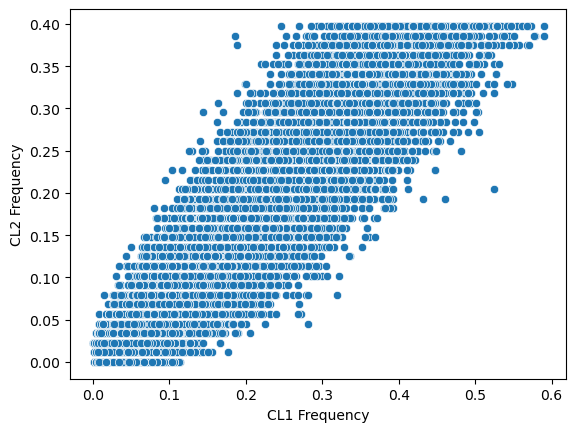

In [71]:
sns.scatterplot(y=cl2_sample.mean(axis=0)[cl2_hfreq_idx], x=cl1_sample.mean(axis=0)[cl2_hfreq_idx])
plt.xlabel('CL1 Frequency')
plt.ylabel('CL2 Frequency')
#plt.savefig('Charts/frequency_clusters.pdf')